# 6. Comparison of methods

In this section, we will compare the performance of the different methods we have implemented so far:
- Fourier Galerkin spectral method
- Chebyshev-Tau spectral method
- BDF2 finite difference method with coordinate transformation
- Physics-informed neural network (PINN) method

First we import all the modules:

In [1]:
using Pkg
Pkg.activate("..") # activate BurgersJoint environment
Pkg.instantiate() # install all dependencies if necessary
using BurgersJoint
using BurgersJoint.BurgersEquation
using BurgersJoint.FourierSpectral
using BurgersJoint.ChebyshevTau
using BurgersJoint.FiniteDifference
using BurgersJoint.NeuralNetwork
using Plots
using Statistics

  Activating project at `~/Documents/ACFPD/Individual assignment/BurgersJoint`


## Study of error convergence

In the interest of time, we will just look at how the error (RMSE) wrt. the analytical solution behaves with the spatial and temporal discretization for the Fourier Galerkin, Chebyshev-Tau, and finite difference methods. The PINN method is not included ,in this study, as it would require a lot of time to train the neural network for each spacing. And in real-life scenarios, grid training would not be used, so the idea of having a discrete grid is not relevant for PINNs.

The study will be conducted for the default parameters of the problem and the solvers unless otherwise stated. 

The study uses a final time of $T=3/\pi$.

In [79]:
solvers = [solveFourierSpectral, solveChebyshevTau, solveFiniteDifference]

T = 3/pi
N_list = [16, 32, 64, 128, 256, 512, 1024] # Number of grid points
dt_list = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001] # Time step sizes

RMSE_list = zeros(length(solvers), length(N_list), length(dt_list))

# Loop over solvers
for (i, solver) in enumerate(solvers)
    println("Solver: ", solver)
    # Loop over N
    for (j, N) in enumerate(N_list)
        # Loop over dt
        for (k, dt) in enumerate(dt_list)
            x, u_num, _, _  = solver(N; dt=dt, T=T) # Numerical solution
            u_ana = analytical_solution(x, T;n=100) # Analytical solution, we use quadrature with n=100 nodes for an accurate solution (not sure how many digits though)
            RMSE_list[i, j, k] = sqrt(mean((u_num - u_ana).^2)) # RMSE
        end
    end
end


Solving: 100%[==========================================] Time: 0:00:01
Solving: 100%[==========================================] Time: 0:00:00
Solving: 100%[==========================================] Time: 0:00:01
Solving: 100%[==========================================] Time: 0:00:05
Solving: 100%[==========================================] Time: 0:00:00
Solving: 100%[==========================================] Time: 0:00:02
Solving: 100%[==========================================] Time: 0:00:05
Solving: 100%[==========================================] Time: 0:00:26
Solving: 100%[==========================================] Time: 0:00:00
Solving: 100%[==========================================] Time: 0:00:01
Solving: 100%[==========================================] Time: 0:00:02
Solving: 100%[==========================================] Time: 0:00:11
Solving: 100%[==========================================] Time: 0:00:23
Solving: 100%[==========================================] Time: 

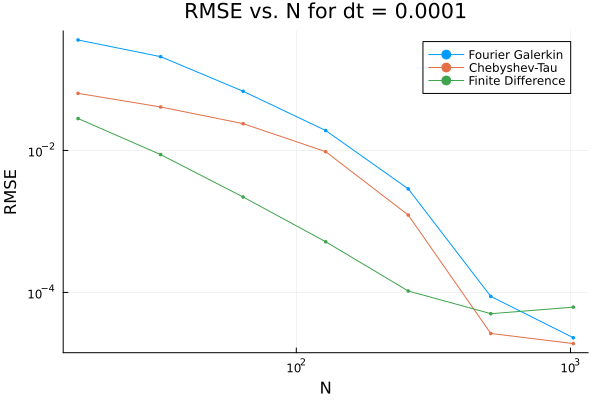

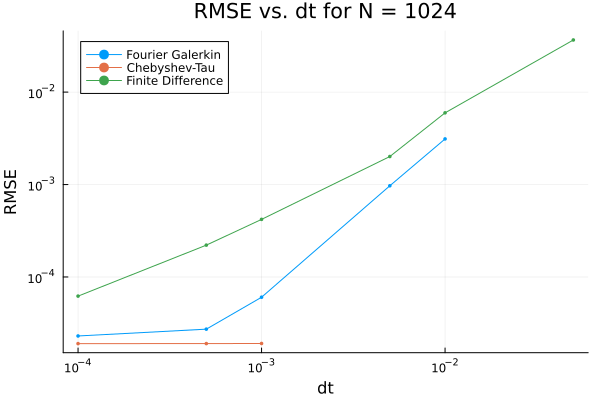

In [80]:
# Plotting
labels = ["Fourier Galerkin", "Chebyshev-Tau", "Finite Difference"]

# RMSE vs. N for each solver at smallest dt
dt_end = dt_list[end]
plt = plot(title="RMSE vs. N for dt = $dt_end", xlabel="N", ylabel="RMSE", yscale=:log, xscale=:log)
for (i, solver) in enumerate(solvers)
    plot!(plt, N_list, RMSE_list[i, :, end], label=labels[i], marker=:circle, markersize=2, markerstrokewidth=0)
end
display(plt)

# RMSE vs. dt for each solver at largest N
N_end = N_list[end]
plt = plot(title="RMSE vs. dt for N = $N_end", xlabel="dt", ylabel="RMSE", yscale=:log, xscale=:log)
for (i, solver) in enumerate(solvers)
    plot!(plt, dt_list, RMSE_list[i, end, :], label=labels[i], marker=:circle, markersize=2, markerstrokewidth=0)
end
display(plt)



**Spatial convergence:**

Considering the plot of RMSE vs. N we see that both Fourier Galerkin and Chebyshev-Tau methods show exponential (spectral) convergence as expected of spectral methods, with the Chebyshev-Tau method converging faster than the Fourier Galerkin method. The finite difference method shows polynomial convergence, which is expected as it is a second-order method in space (using a three-point stencil). For low $N$, the finite difference method has lowest error, but as $N$ increases, the spectral methods outperform it due to spectral convergence.

**Temporal convergence:**
Considering the plot of RMSE vs. dt we first notice that for fine timesteps, Chebyshev-Tau has the lowest error, followed by Fourier Galerkin method, and then finite difference, given same number of spatial points. However, for $\Delta t>10^{-3}$, the Chebyshev-Tau method diverges. Perhaps solving the half-domain so the collocation points would be more concentrated around the high-gradient region would improve stability of Chebyshev-Tau. Only the finite difference method is stable for all $\Delta t$ considered, probably because it uses an implicit method for time-integration (BDF2). For both Fourier Galerkin and finite difference methods, the error appears to be polynomial in $\Delta t$. We expect the error to be second-order in $\Delta t$ for both methods, as both methods use a second-order method in time, the leapfrog-like scheme and BDF2, respectively for Fourier and finite difference.

### Study of convergence order

We first study the spatial convergence of the finite difference method (the others were exponentially convergent):

Estimated convergence order: -2.017497265610892


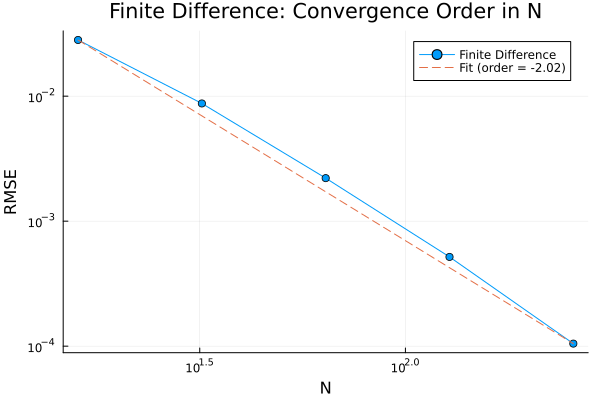

In [82]:
# Convergence order in N for finite difference for the last dt
i = 3 # Finite difference
solver = solvers[i]
label = labels[i]
N_list_conv = N_list[1:end-2] # Exclude the last N for convergence order
rmse_fd = RMSE_list[i, 1:length(N_list_conv), end]
orders = diff(log10.(rmse_fd)) ./ diff(log10.(N_list_conv))
mean_order = mean(orders)
c = rmse_fd[1] / N_list_conv[1]^mean_order
fitted_line = c .* (N_list_conv .^ mean_order)
println("Estimated convergence order: ", mean_order)

plt_fd = plot(N_list_conv, rmse_fd, marker=:circle, xlabel="N", ylabel="RMSE",
              xscale=:log10, yscale=:log10, label=label,
              title="Finite Difference: Convergence Order in N")
plot!(N_list_conv, fitted_line, linestyle=:dash,
      label="Fit (order = $(round(mean_order, digits=2)))")
display(plt_fd)

This is almost exactly $O(N^{-2})$ convergence, as expected from the second-order discretization of the spatial derivatives used in the method.

We now study the temporal convergence of the Fourier Galerkin and the finite difference methods:

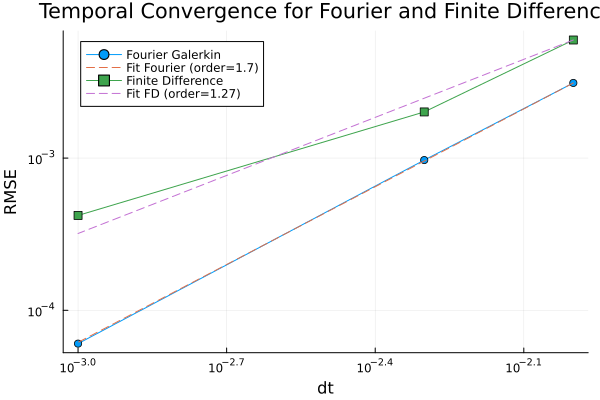

In [ ]:
# Convergence order in dt for Fourier and finite difference for the last N
idx_range = 2:4 # Index range for power-law like region
dt_list_conv = dt_list[idx_range] 

# For Fourier Spectral method (index 1)
rmse_fourier = RMSE_list[1, end, idx_range]
orders_fourier = diff(log10.(rmse_fourier)) ./ diff(log10.(dt_list_conv))
mean_order_fourier = mean(orders_fourier)
c_fourier = rmse_fourier[1] / dt_list_conv[1]^mean_order_fourier
fitted_fourier = c_fourier .* (dt_list_conv .^ mean_order_fourier)

# For Finite Difference method (index 3)
rmse_fd_dt = RMSE_list[3, end, idx_range]
orders_fd = diff(log10.(rmse_fd_dt)) ./ diff(log10.(dt_list_conv))
mean_order_fd = mean(orders_fd)
c_fd = rmse_fd_dt[1] / dt_list_conv[1]^mean_order_fd
fitted_fd = c_fd .* (dt_list_conv .^ mean_order_fd)

# Plotting both temporal convergence curves and their fitted lines
plt_dt = plot(dt_list_conv, rmse_fourier, marker=:circle, xlabel="dt", ylabel="RMSE",
              xscale=:log10, yscale=:log10, label=labels[1],
              title="Temporal Convergence for Fourier and Finite Difference")
plot!(dt_list_conv, fitted_fourier, linestyle=:dash,
      label="Fit Fourier (order=$(round(mean_order_fourier, digits=2)))")
plot!(dt_list_conv, rmse_fd_dt, marker=:square, label=labels[3])
plot!(dt_list_conv, fitted_fd, linestyle=:dash,
      label="Fit FD (order=$(round(mean_order_fd, digits=2)))")
display(plt_dt)

As stated earlier, we expect the error to be second-order in $\Delta t$ for both methods, as both methods use a second-order method for time integration. The results are not quite the expected $O(\Delta t^2)$ however, but seemingly $O(\Delta t^{1.7})$ for Fourier and $O(\Delta t^{1.3})$ for finite difference. This could be due to spatial discretization errors or that the solution is not smooth enough in time. 